## Quora Insincere Questions Classification - Part I - Naive Bayes
This notebook addresses the Quora Insincere Questions Classification Kaggle competition (https://www.kaggle.com/c/quora-insincere-questions-classification). In this, the first of 2 parts, a simple Naive Bayes classifier is used to detect insincere question submissions. As F1 score is the metric used to rank submissions in the competition, it is this metric that the classifier will be optimised for. 

Firstly, we'll load the necessary libraries and read the csv files into dataframes:

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import matplotlib
from matplotlib import pyplot as plt

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['embeddings', 'train.csv', 'sample_submission.csv', 'test.csv']


Load in the training and test files:


In [24]:
#Load in the training and test sets
trainset = pd.read_csv('../input/train.csv')
testset = pd.read_csv('../input/test.csv')

#Inspect that everything looks as it should:
print(trainset.head())
print(trainset.columns)
print(trainset.shape)

#Check how balanced the training set is
print(trainset['target'].value_counts())


                    qid  ...   target
0  00002165364db923c7e6  ...        0
1  000032939017120e6e44  ...        0
2  0000412ca6e4628ce2cf  ...        0
3  000042bf85aa498cd78e  ...        0
4  0000455dfa3e01eae3af  ...        0

[5 rows x 3 columns]
Index(['qid', 'question_text', 'target'], dtype='object')
(1306122, 3)
0    1225312
1      80810
Name: target, dtype: int64


Note there are around 15 'sincere' tagged questions for every sincere question, making the dataset somewhat unbalanced. 

In [25]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return(text)

# apply the above function to the train and test sets
trainset['cleaned_text'] = trainset['question_text'].map(lambda x: clean_text(x))
testset['cleaned_text'] = testset['question_text'].map(lambda x: clean_text(x))

Check that the text cleaning has worked

In [26]:
print(trainset[['question_text', 'cleaned_text']][0:5])
print(testset[['question_text', 'cleaned_text']][0:5])

                                       question_text                                     cleaned_text
0  How did Quebec nationalists see their province...      quebec nationalist see provinc nation 1960s
1  Do you have an adopted dog, how would you enco...        adopt dog would encourag peopl adopt shop
2  Why does velocity affect time? Does velocity a...    veloc affect time veloc affect space geometri
3  How did Otto von Guericke used the Magdeburg h...         otto von guerick use magdeburg hemispher
4  Can I convert montra helicon D to a mountain b...  convert montra helicon mountain bike chang tyre
                                       question_text                                       cleaned_text
0  My voice range is A2-C5. My chest voice goes u...  voic rang a2 - c5 chest voic goe f4 includ sam...
1           How much does a tutor earn in Bangalore?                           much tutor earn bangalor
2  What are the best made pocket knives under $20...                   best 

In [27]:
#split the training data into training and validation sets

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(trainset[['qid','question_text','cleaned_text']], trainset['target'], test_size=0.1)
                                                        
#Check sizes
print('X_train, X_val, y_train, y_val')
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


X_train, X_val, y_train, y_val
(1175509, 3) (130613, 3) (1175509,) (130613,)


In [28]:
#Train a Vectorizor using all the words in the X_train dataset:

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=5).fit(X_train['cleaned_text'])

#Create a feature from the Vectorised Transformations of the question text columns for
#each of the train, validation and test sets:

X_train_T = vect.transform(X_train['cleaned_text'])
X_val_T = vect.transform(X_val['cleaned_text'])
testset_T = vect.transform(testset['cleaned_text'])


We now have features only based on the presence of words in the dictionary. There might be some other features that can assist the model. Let's see if the length of the question text is related to the target value:

In [29]:
#See if length is related to insincerity
trainset['length']=[len(s) for s in trainset['question_text']]

print(trainset.groupby('target')['length'].mean())

target
0    68.872758
1    98.064163
Name: length, dtype: float64


Length is somewhat correlated with sincerity, so may be a useful feature. Let's add it to the feature list:

In [30]:
X_train_len = [len(s) for s in X_train['question_text'].values]
X_val_len = [len(s) for s in X_val['question_text'].values]
testset_len= [len(s) for s in testset['question_text'].values]

print('X_train_T shape before:', np.shape(X_train_T))

#A function to quickly add new features
def add_feature(X, feature_to_add):
    from scipy.sparse import csr_matrix, hstack
    return (hstack([X, csr_matrix(feature_to_add).T]))

X_train_T = add_feature(X_train_T, X_train_len)
X_val_T = add_feature(X_val_T, X_val_len)
testset_T = add_feature(testset_T, testset_len)

#Check that adding a feature has added one column

print('X_train_T shape after:', np.shape(X_train_T))


X_train_T shape before: (1175509, 33595)
X_train_T shape after: (1175509, 33596)


In [31]:
#Train a classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, recall_score, f1_score

grid = [{'alpha':[0.1,0.5,1,2,3,5],
         'fit_prior':[True, False]}]

NB_classifier = GridSearchCV(MultinomialNB(), cv=5, param_grid=grid, scoring='f1').fit(X_train_T, y_train)
NB_preds = NB_classifier.predict(X_val_T)

print('Best Parameters:')
print(NB_classifier.best_estimator_.get_params())

print('Naive Bayes Recall =', recall_score(y_val, NB_preds))
print('Naive Bayes ROC AUC SCORE =', roc_auc_score(y_val, NB_preds))
print('Naive Bayes F1 SCORE =', f1_score(y_val, NB_preds))


Best Parameters:
{'alpha': 2, 'class_prior': None, 'fit_prior': True}
Naive Bayes Recall = 0.6905468943330859
Naive Bayes ROC AUC SCORE = 0.8177987672896139
Naive Bayes F1 SCORE = 0.5472641694449892


The best threshold was  0.62 with a maximum F1 score of  0.5534678977882758


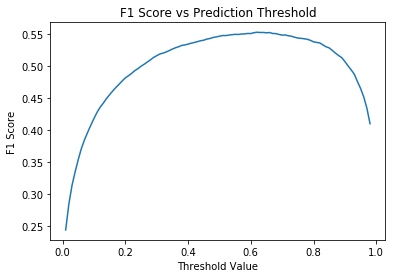

In [32]:
#Get the F1 score for each threshold in the range 0.01 to 0.99:
f1_scores = []
maxf1 = 0 

for thresh in np.arange(0.01, 0.99, 0.01):
    probs = NB_classifier.predict_proba(X_val_T)
    preds = [1 if probs[a][1] > thresh else 0 for a in range(len(probs))]
    f1 = f1_score(y_val, preds)
    f1_scores.append(f1)
    if f1 > maxf1: 
        maxf1 = f1 
        best_thresh = thresh

print('The best threshold was ', best_thresh, 'with a maximum F1 score of ', maxf1)
#Plot F1 score vs threshold value
plt.plot(np.arange(0.01, 0.99, 0.01),f1_scores, label='F1 score by threshold')
plt.ylabel('F1 Score')
plt.xlabel('Threshold Value')
plt.title('F1 Score vs Prediction Threshold')
plt.show()

Run predictions on the test set and produce a datafile for submission:

In [33]:

#Get testset probabilities
test_probs = NB_classifier.predict_proba(testset_T)

#Convert testset probabilities to predictions using the optimal threshold
test_preds = [1 if test_probs[a][1] > 0.62 else 0 for a in range(len(test_probs))]

#Put predictions into the appropriate format for submission
submission_table = pd.DataFrame(test_preds, testset['qid'])
submission_table.columns=['prediction']
submission_table.to_csv('submission.csv')

 ## Summary
The simple Naive Bayes classifier achieved an F1-score of 0.541 on the test set. This provides a base-line performance to which the performance of the Neural Network based solutions. 